# Exp3: xgboost With Almost no PP/FE 

In [1]:
# import packages
import gc
import os
import sys
import time
from contextlib import contextmanager
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import seaborn as sns
import xgboost as xgb
from IPython.core.display import HTML, display
from ipywidgets import interact
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from tqdm import tqdm_notebook as tqdm

PROJECT_DIR = "/app"
INPUT_FILE_PATH = Path("../..")
sys.path.insert(0, PROJECT_DIR)

# enable plotly offline plotting
plotly.offline.init_notebook_mode(connected=True)

# change figsize of seaborn
sns.set(rc={"figure.figsize": (8, 6)})

display(HTML("<style>.container { width:88% !important; }</style>"))

In [2]:
# import modules
from src.logger.main import LOGGER, setup_logger
from src.preprocess.main import pp
from src.preprocess.read_file import read_file

In [6]:
# settings
EXP_ID = "exp3"
DATA_DIR = "../../input"
SEED = np.random.randint(100000)
LOGGER_PATH = "{}_log.txt".format(EXP_ID)
os.remove(LOGGER_PATH)
ID_COLUMNS = "id"
TARGET_COLUMNS = ["target"]
N_CLASSES = len(TARGET_COLUMNS)

fold_id = 1
OUTPUT_PATH = "{}_fold{}.pth".format(EXP_ID, fold_id)

setup_logger(out_file=LOGGER_PATH)
LOGGER.info("seed={}".format(SEED))

2019-10-26 13:13:56,351 - INFO - logger set up
2019-10-26 13:13:56,354 - INFO - seed=57819


In [7]:
# timer set up 
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    LOGGER.info('[{}] done in {} s'.format(name, round(time.time() - t0, 2)))

In [8]:
with timer('load data'):
    df, _ = read_file(DATA_DIR=DATA_DIR)
    y = df[TARGET_COLUMNS].values
    ids = df[[ID_COLUMNS]] 
    gc.collect()

2019-10-26 13:13:59,019 - INFO - [load data] done in 1.08 s


In [9]:
with timer('preprocessing'):
    df = pp(df)
    
    # fill NaN with most frequent values
    df.loc[:, 'direction'] = df['direction'].fillna(df['direction'].value_counts().index[0])
    df.loc[:, 'material'] = df['material'].fillna(df['material'].value_counts().index[0])
    df.loc[:, 'layout'] = df['layout'].fillna(df['direction'].value_counts().index[0])
    
    # One-Hot Encoding
    df = pd.concat([df, pd.get_dummies(df["direction"], prefix="ohe_direction")], axis=1)
    df = pd.concat([df, pd.get_dummies(df["layout"], prefix="ohe_layout")], axis=1)
    df = pd.concat([df, pd.get_dummies(df["material"], prefix="ohe_material")], axis=1)

    # Drop unused columns
    df = df.drop(['id', 'layout', 'material', 'direction', 'neighbor'], axis=1)
    
    df.loc[:, 'target_log'] = np.log(df['target'])

2019-10-26 13:14:03,026 - INFO - [preprocessing] done in 3.92 s


In [10]:
# show correlation of one variable 
target_col_name = "target_log"
corr = df.corr()
index_sort_by_corr = (
    np.abs(corr.drop(["target", "target_log"])[target_col_name])
    .sort_values(ascending=False)
    .index
)

@interact(col_name=index_sort_by_corr)
def show_ohe_boxplot(col_name):
    sns.scatterplot(x=col_name, y=target_col_name, data=df).set_title(
        "corr_coef: {}".format(corr[col_name][target_col_name])
    )

interactive(children=(Dropdown(description='col_name', options=('area', 'ohe_bathroom_洗面台独立', 'ohe_kitchen_コンロ…

In [11]:
rename_cols = {}
i = 1
for col_name in df.filter(like="ohe_").columns:
    rename_cols[col_name] = "_".join(col_name.split('_')[:2]) + "_{}".format(i)
    i += 1
df = df.rename(columns=rename_cols) 

In [13]:
# xgb parameters
params = {
     # 回帰問題
    'objective': 'reg:linear',
    # 学習用の指標 (RMSE)
    'eval_metric': 'rmse',
}

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:657: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



[13:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


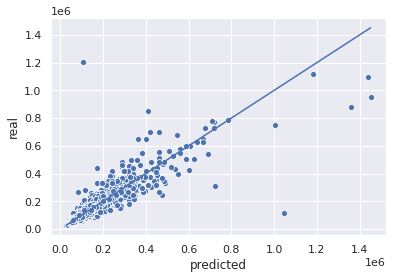

No.0 Score: 32121.468658715126
[13:18:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


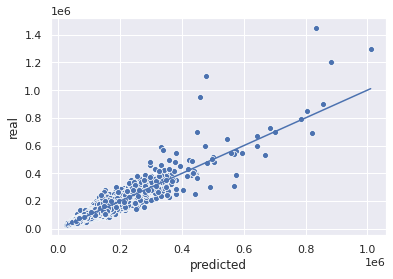

No.1 Score: 25719.623317973837
[13:18:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


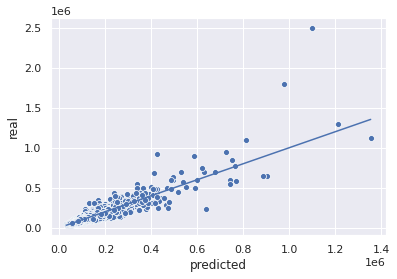

No.2 Score: 32666.098311061884
[13:19:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


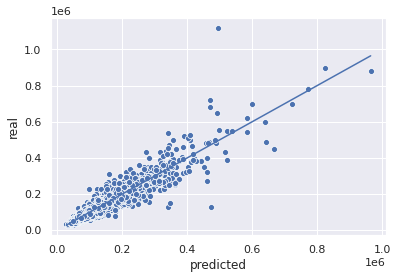

No.3 Score: 23684.81590167513
[13:19:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


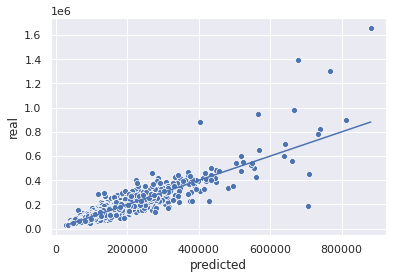

2019-10-26 13:19:15,287 - INFO - [Cross Validation] done in 33.48 s


No.4 Score: 28470.762719870476


In [16]:
with timer("Cross Validation"):
    scores = []
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0).split(df, y)
    for n_fold, (train_index, val_index) in enumerate(folds):
        train_df = df.loc[train_index]
        val_df = df.loc[val_index]
        y_train = y[train_index]
        y_val = y[val_index]

        dtrain = xgb.DMatrix(train_df.drop(["target", "target_log"], axis=1), label=y_train.flatten())
        dtest = xgb.DMatrix(val_df.drop(["target", "target_log"], axis=1), label=y_val.flatten())

        gbm = xgb.train(
            params,
            dtrain,
            num_boost_round=100,  # 学習ラウンド数は適当
        )
        
        y_pred = gbm.predict(dtest)

        # see the correlation between real and prediction
        ax = sns.scatterplot(x=y_pred.flatten(), y=y_val.flatten())
        ax = sns.lineplot(
            x=[y_pred.flatten().min(), y_pred.flatten().max()],
            y=[y_pred.flatten().min(), y_pred.flatten().max()],
        )
        ax.set(xlabel="predicted", ylabel="real")
        plt.show()

        score = np.sqrt(
            ((y_pred.flatten() - y_val.flatten()) ** 2).sum() / len(y_val.flatten())
        )
        scores.append(score)
        print("No.{} Score: {}".format(n_fold, score))

In [17]:
np.mean(scores)

28532.553781859293